
# Importing modules and tools


In [1]:

%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

from datasets.platgesbcn_segmentation_dataset import PlatgesBCNSegmentationDataset
from other_algorithms.mask_translator import MaskTranslator



# Initial test

If the images are similar, wouldn't they stich correctly authomatically (and their masks with them)?


## First step

Let's define a function to process a pair of images

In [2]:

# TODO: homografias => IoU en area solapada
def genera_error_annotaciones(image1, image2, mask1, mask2, max_size_x=4000, max_size_y=4000, downsampling=10):

    mask_translator = MaskTranslator()

    # Downsampling
    image1 = cv2.cvtColor(np.uint8(image1[::downsampling, ::downsampling]), cv2.COLOR_RGB2GRAY)
    image2 = cv2.cvtColor(np.uint8(image2[::downsampling, ::downsampling]), cv2.COLOR_RGB2GRAY)
    mask1 = np.uint8(mask1[::downsampling, ::downsampling])
    mask2 = np.uint8(mask2[::downsampling, ::downsampling])

    # Processing
    mask_translator.train()
    mask1_h, mask2_h, img1_h, img2_h = mask_translator(image1, image2, mask1, mask2)

    # logging
    print(f"Error pixels: {np.sum(mask1_h != mask2_h)}")
    print(f"Correct pixels: {np.sum(mask1_h == mask2_h)}")
    print(f"image1.shape = {img1_h.shape}\timage2.shape = {img2_h.shape}")
    print(f"cropping the upper left corner, shape {max_size_x}x{max_size_y}")
    print(f"Error pixels: {np.sum(mask1_h[:max_size_x, :max_size_y] != mask2_h[:max_size_x, :max_size_y])}")
    print(f"Correct pixels: {np.sum(mask1_h[:max_size_x, :max_size_y] == mask2_h[:max_size_x, :max_size_y])}")
    print(f"\n---\n")

    # Drawing
    img1_h = img1_h[:max_size_x, :max_size_y]
    img2_h = img2_h[:max_size_x, :max_size_y]
    mask1_h = mask1_h[:max_size_x, :max_size_y]
    mask2_h = mask2_h[:max_size_x, :max_size_y]

    composed_img = img1_h.copy()
    composed_img[composed_img == 0] = img2_h[composed_img == 0]
    composed_img = cv2.cvtColor(composed_img, cv2.COLOR_GRAY2BGR)

    error_mask = (mask1_h != mask2_h).astype(np.uint8) * 255
    error_mask_color = cv2.cvtColor(error_mask, cv2.COLOR_GRAY2BGR)
    error_mask_color[error_mask == 255] = (0, 0, 255)

    blend_img = cv2.addWeighted(composed_img, 0.7, error_mask_color, 0.3, 0)
    return blend_img



## Second step

Let's load some images and see how it works

Error pixels: 117409
Correct pixels: 170233055
image1.shape = (8614, 19776)	image2.shape = (8614, 19776)
cropping the upper left corner, shape 2000x2000
Error pixels: 117409
Correct pixels: 3882591

---



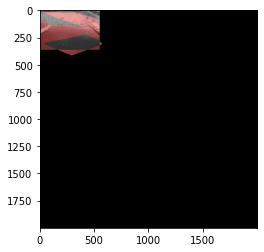

Error pixels: 164084
Correct pixels: 1066124
image1.shape = (448, 2746)	image2.shape = (448, 2746)
cropping the upper left corner, shape 2000x2000
Error pixels: 164084
Correct pixels: 731916

---



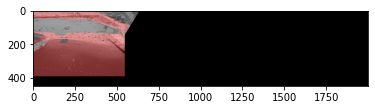

Error pixels: 143529
Correct pixels: 56491
image1.shape = (365, 548)	image2.shape = (365, 548)
cropping the upper left corner, shape 2000x2000
Error pixels: 143529
Correct pixels: 56491

---



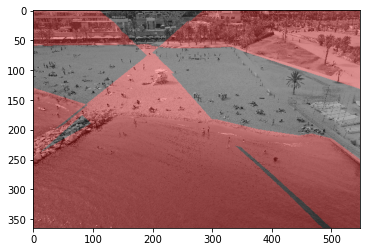

Error pixels: 2299311
Correct pixels: 70733
image1.shape = (892, 2657)	image2.shape = (892, 2657)
cropping the upper left corner, shape 2000x2000
Error pixels: 1715794
Correct pixels: 68206

---



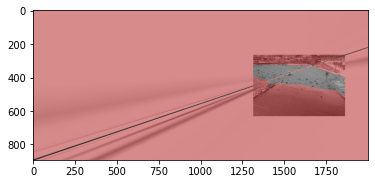

Error pixels: 146255
Correct pixels: 53765
image1.shape = (365, 548)	image2.shape = (365, 548)
cropping the upper left corner, shape 2000x2000
Error pixels: 146255
Correct pixels: 53765

---



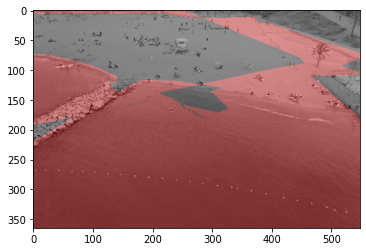

In [3]:

barcos_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_barcos_wide.csv')
gradas_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_gradas_wide.csv')
pipican_wide = PlatgesBCNSegmentationDataset('./data_lists/platgesbcn2021_pipican_wide.csv')

datasets = {'barcos_wide' : barcos_wide, 'gradas_wide' : gradas_wide, 'pipican_wide' : pipican_wide}

num_imgs = 0
max_images = 4

# For the notebook, 1 dataset is enough (adding list(·)[:1])
for dataset_name, dataset in list(datasets.items())[:1]:
        for i, (image1, mask1, img_path1, classes1) in enumerate(dataset):
            for j, (image2, mask2, img_path2, classes2) in enumerate(dataset):
                if i == j : continue
                if num_imgs > max_images : break
                
                blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, max_size_x=2000, max_size_y=2000, downsampling=10)
                
                # cv2.imwrite(f'/mnt/c/Users/Ignasi/Downloads/ensayo_reaprovechar_annotaciones/{dataset_name}_{i}-{j}.jpg', blend_img)
                
                plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
                plt.show()
                
                num_imgs += 1



It is pretty bad... Let's see if handpicking the points works or it is needed to continue with the semantic segmentation.


------

In [ ]:
import os
os._exit(00)
%reset -f

---


# Handpicking points

Will a human pick points better than an algorithm? Or will we discard this idea?

In [1]:

%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np
import pickle



## First step

Defining useful functions.

As it is ugly to work with handpicked points, let's drop a little the coding considerations.

In [2]:

def load_img(img_path, seg_path, cls_path):

    image = cv2.imread(img_path, 0)

    with open(seg_path, 'rb') as f:
        mask = pickle.load(f, encoding='latin1')
    with open(cls_path, 'rb') as f:
        classes = pickle.load(f)

    return image, mask, classes

def homography_matrix_estimator(kp1, kp2, ransac_th=5.0, ransac_maxIters=1000):
    kp1 = np.float32([kp.pt for kp in kp1]).reshape(-1, 1, 2)
    kp2 = np.float32([kp.pt for kp in kp2]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(kp1, kp2, cv2.RANSAC, ransac_th, maxIters=ransac_maxIters)
    return H

def compute_dimensions(composed_img, current_img, homography_matrix):
    h, w = composed_img.shape
    composed_corners = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1,1,2).squeeze().astype(int)

    h, w = current_img.shape
    pts = np.float32([ [0,0], [0,h-1], [w-1,h-1], [w-1,0] ]).reshape(-1,1,2)
    next_corners = cv2.perspectiveTransform(pts, homography_matrix)
    next_corners = np.squeeze(next_corners) # Remove extra dimensions
    next_corners = np.round(next_corners).astype(int)   # Convert to integer

    x_coord = np.concatenate([composed_corners, next_corners]).squeeze()[:,0]
    y_coord =  np.concatenate([composed_corners, next_corners]).squeeze()[:,1]

    max_x = x_coord.max()
    min_x = x_coord.min()
    max_y = y_coord.max()
    min_y = y_coord.min()
    
    return max_x, min_x, max_y, min_y

def genera_error_annotaciones(image1, image2, mask1, mask2, H, max_size_x=4000, max_size_y=4000):

    image1 = np.uint8(image1)
    image2 = np.uint8(image2)
    mask1 = np.uint8(mask1)
    mask2 = np.uint8(mask2)

    # Processing
    max_x, min_x, max_y, min_y = compute_dimensions(image1, image2, H)
    width = int(max_x - min_x + 1)
    height = int(max_y - min_y + 1)
    
    translation_matrix = np.matrix([[1.0, 0.0, -min_x],[0.0, 1.0, -min_y],[0.0, 0.0, 1.0]])
    h = translation_matrix * H # * image

    mask1_h = cv2.warpPerspective(mask1, translation_matrix, (width, height), flags=cv2.INTER_LINEAR) # mask1 translated
    mask2_h = cv2.warpPerspective(mask2, h, (width, height), flags=cv2.INTER_LINEAR) #mask2 homography into 1 translated

    img1_h = cv2.warpPerspective(image1, translation_matrix, (width, height), flags=cv2.INTER_LINEAR)
    img2_h = cv2.warpPerspective(image2, h, (width, height), flags=cv2.INTER_LINEAR)

    # logging
    print(f"Error pixels: {np.sum(mask1_h != mask2_h):,}")
    print(f"Correct pixels: {np.sum(mask1_h == mask2_h):,}")
    print(f"image1.shape = {img1_h.shape}\timage2.shape = {img2_h.shape}")
    print(f"cropping the upper left corner, shape {max_size_x}x{max_size_y}")
    print(f"Error pixels: {np.sum(mask1_h[:max_size_x, :max_size_y] != mask2_h[:max_size_x, :max_size_y]):,}")
    print(f"Correct pixels: {np.sum(mask1_h[:max_size_x, :max_size_y] == mask2_h[:max_size_x, :max_size_y]):,}")
    print(f"\n---\n")

    # Drawing
    img1_h = img1_h[:max_size_x, :max_size_y]
    img2_h = img2_h[:max_size_x, :max_size_y]
    mask1_h = mask1_h[:max_size_x, :max_size_y]
    mask2_h = mask2_h[:max_size_x, :max_size_y]

    composed_img = img1_h.copy()
    composed_img[composed_img == 0] = img2_h[composed_img == 0]
    composed_img = cv2.cvtColor(composed_img, cv2.COLOR_GRAY2BGR)

    error_mask = (mask1_h != mask2_h).astype(np.uint8) * 255
    error_mask_color = cv2.cvtColor(error_mask, cv2.COLOR_GRAY2BGR)
    error_mask_color[error_mask == 255] = (0, 0, 255)

    blend_img = cv2.addWeighted(composed_img, 0.7, error_mask_color, 0.3, 0)
    return blend_img



## Second step

Let's see what we have


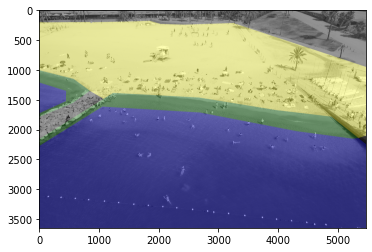

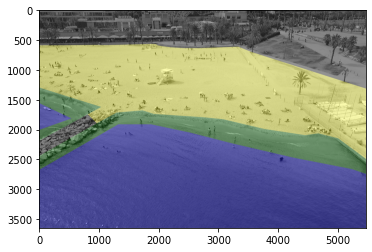

In [3]:
DATA_ROOT = "/mnt/c/Users/Ignasi/Downloads/platgesbcn2021_miniset/barcos_wide/"
IMG1_NAME = "DJI_0581"
IMG2_NAME = "DJI_0722"


IMG1_PATH = f"{DATA_ROOT}/{IMG1_NAME}.JPG"
SEGS1_PATH = f"{DATA_ROOT}/{IMG1_NAME}.segments.pkl"
CLS1_PATH = f"{DATA_ROOT}/{IMG1_NAME}.classes.pkl"
IMG2_PATH = f"{DATA_ROOT}/{IMG2_NAME}.JPG"
SEGS2_PATH = f"{DATA_ROOT}/{IMG2_NAME}.segments.pkl"
CLS2_PATH = f"{DATA_ROOT}/{IMG2_NAME}.classes.pkl"


BGR_BLUE = (255, 0, 0)
BGR_YELLOW = (0, 255, 255)
BGR_HALF_GREEN = (0, 128, 0)


image1, mask1, classes1 = load_img(IMG1_PATH, SEGS1_PATH, CLS1_PATH)
image2, mask2, classes2 = load_img(IMG2_PATH, SEGS2_PATH, CLS2_PATH)

def color_mask(mask):
    def color_cls(mask, cls_, color):
        mask_b = (mask == cls_).astype(np.uint8) * 255
        mask_c = cv2.cvtColor(mask_b, cv2.COLOR_GRAY2BGR)
        mask_c[mask_b == 255] = color
        return mask_c
    
    mask_c = cv2.addWeighted(color_cls(mask, 1, BGR_BLUE), 1, color_cls(mask, 2, BGR_YELLOW), 1, 0)
    mask_c = cv2.addWeighted(mask_c, 1, color_cls(mask, 3, BGR_HALF_GREEN), 1, 0)
    return mask_c

mask1_c = cv2.cvtColor(color_mask(mask1), cv2.COLOR_BGR2RGB)
blend_img = cv2.addWeighted(cv2.cvtColor(image1, cv2.COLOR_GRAY2RGB), 0.7, mask1_c, 0.3, 0)
plt.imshow(blend_img)
plt.show()

mask2_c = cv2.cvtColor(color_mask(mask2), cv2.COLOR_BGR2RGB)
blend_img = cv2.addWeighted(cv2.cvtColor(image2, cv2.COLOR_GRAY2RGB), 0.7, mask2_c, 0.3, 0)
plt.imshow(blend_img)
plt.show()



## Third step

First let's try a dummy code test and have a working example. As we have a test, let's make it easy.

Let's see what happen if the points are coincidents.


[[ 1.00000000e+00  0.00000000e+00 -3.84592537e-16]
 [ 0.00000000e+00  1.00000000e+00 -7.69185075e-16]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Error pixels: 6,077,862
Correct pixels: 13,883,994
image1.shape = (3648, 5472)	image2.shape = (3648, 5472)
cropping the upper left corner, shape 8000x8000
Error pixels: 6,077,862
Correct pixels: 13,883,994

---



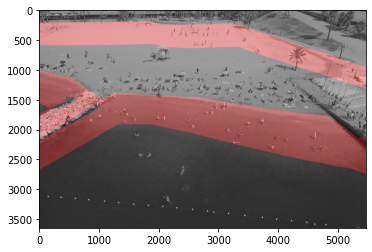

Error pixels: 6,077,862
Correct pixels: 13,883,994
image1.shape = (3648, 5472)	image2.shape = (3648, 5472)
cropping the upper left corner, shape 8000x8000
Error pixels: 6,077,862
Correct pixels: 13,883,994

---



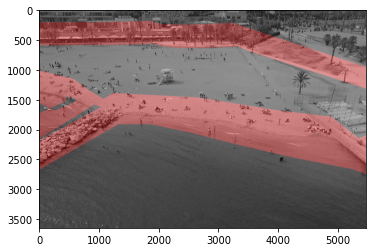

In [4]:

RADI = 2
HANDPICKED_KP = (
    (
        cv2.KeyPoint(0, 0, RADI),
        cv2.KeyPoint(3, 3, RADI),
        cv2.KeyPoint(0, 3, RADI),
        cv2.KeyPoint(3, 0, RADI)
    ),
    (
        cv2.KeyPoint(0, 0, RADI),
        cv2.KeyPoint(3, 3, RADI),
        cv2.KeyPoint(0, 3, RADI),
        cv2.KeyPoint(3, 0, RADI)
    )
)

H = homography_matrix_estimator(HANDPICKED_KP[0], HANDPICKED_KP[1])
print(H, end='\n\n')

blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, np.linalg.inv(H), max_size_x=8000, max_size_y=8000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()

blend_img = genera_error_annotaciones(image2, image1, mask2, mask1, H, max_size_x=8000, max_size_y=8000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()



## Fourth step

Now, let's play with the point coordinates.


[[ 9.53919661e-01 -8.57139022e-02  1.78843541e+02]
 [ 6.17616984e-04  9.46857610e-01  3.93112111e+02]
 [-3.78220725e-06 -1.92933800e-05  1.00000000e+00]]

Error pixels: 3,903,184
Correct pixels: 19,266,515
image1.shape = (4067, 5697)	image2.shape = (4067, 5697)
cropping the upper left corner, shape 8000x8000
Error pixels: 3,903,184
Correct pixels: 19,266,515

---



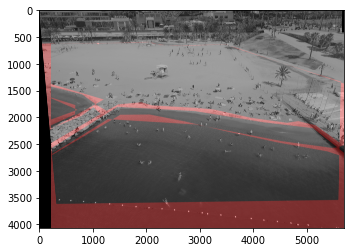

Error pixels: 4,361,202
Correct pixels: 19,953,438
image1.shape = (4236, 5740)	image2.shape = (4236, 5740)
cropping the upper left corner, shape 8000x8000
Error pixels: 4,361,202
Correct pixels: 19,953,438

---



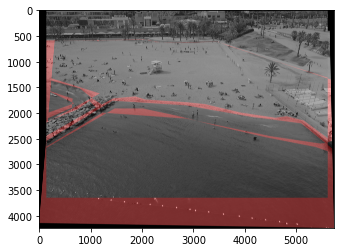

In [5]:
RADI = 2
HANDPICKED_KP = (
    (
        cv2.KeyPoint(4197, 1165, RADI),
        cv2.KeyPoint(2046, 711, RADI),
        cv2.KeyPoint(781, 199, RADI),
        cv2.KeyPoint(3509, 326, RADI),
        cv2.KeyPoint(586, 1708, RADI)
    ),
    (
        cv2.KeyPoint(426, 1564, RADI),
        cv2.KeyPoint(2115, 1091, RADI),
        cv2.KeyPoint(913, 586, RADI),
        cv2.KeyPoint(3568, 718, RADI),
        cv2.KeyPoint(613, 2084, RADI)
    )
)

H = homography_matrix_estimator(HANDPICKED_KP[0], HANDPICKED_KP[1])
print(H, end='\n\n')

blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, np.linalg.inv(H), max_size_x=8000, max_size_y=8000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()

blend_img = genera_error_annotaciones(image2, image1, mask2, mask1, H, max_size_x=8000, max_size_y=8000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()

It seems that it is possible with the most error outside the images, the borders and where one image considers both and the other no (It can be taken as correct).


## Fifth step

Let's try with other images.


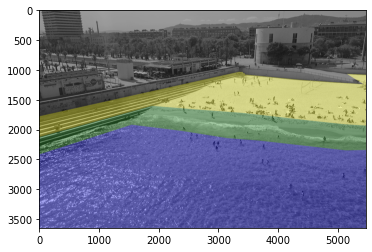

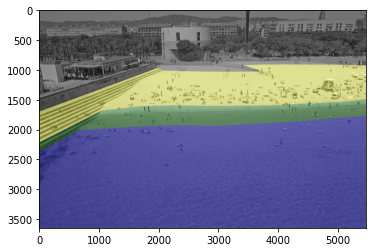

[[ 2.38384615e+00  5.72033887e-01 -5.11775517e+03]
 [ 1.92767269e-01  1.31473614e+00 -2.94199373e+02]
 [ 2.80188057e-04 -1.75583816e-04  1.00000000e+00]]

Error pixels: 12,155,001
Correct pixels: 91,105,581
image1.shape = (6311, 16362)	image2.shape = (6311, 16362)
cropping the upper left corner, shape 20000x20000
Error pixels: 12,155,001
Correct pixels: 91,105,581

---



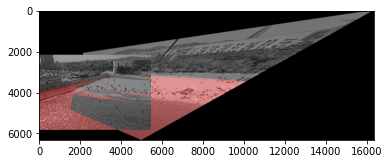

Error pixels: 58,347,163
Correct pixels: 119,710,746
image1.shape = (12809, 13901)	image2.shape = (12809, 13901)
cropping the upper left corner, shape 20000x20000
Error pixels: 58,347,163
Correct pixels: 119,710,746

---



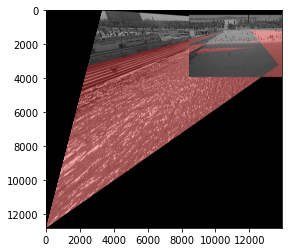

In [6]:
DATA_ROOT = "/mnt/c/Users/Ignasi/Downloads/platgesbcn2021_miniset/gradas_wide/"
IMG1_NAME = "DJI_0701"
IMG2_NAME = "DJI_0788"

RADI = 2
HANDPICKED_KP = (
    (
        cv2.KeyPoint(3352, 1032, RADI),
        cv2.KeyPoint(5416, 1283, RADI),
        cv2.KeyPoint(3658, 1189, RADI),
        cv2.KeyPoint(4386, 1392, RADI)
        #, cv2.KeyPoint(5049, 1209, RADI)
    ),
    (
        cv2.KeyPoint(1970, 972, RADI),
        cv2.KeyPoint(3720, 1063, RADI),
        cv2.KeyPoint(2358, 1087, RADI),
        cv2.KeyPoint(3091, 1200, RADI)
        #, cv2.KeyPoint(3435, 1028, RADI)
    )
)

########################################################

IMG1_PATH = f"{DATA_ROOT}/{IMG1_NAME}.JPG"
SEGS1_PATH = f"{DATA_ROOT}/{IMG1_NAME}.segments.pkl"
CLS1_PATH = f"{DATA_ROOT}/{IMG1_NAME}.classes.pkl"
IMG2_PATH = f"{DATA_ROOT}/{IMG2_NAME}.JPG"
SEGS2_PATH = f"{DATA_ROOT}/{IMG2_NAME}.segments.pkl"
CLS2_PATH = f"{DATA_ROOT}/{IMG2_NAME}.classes.pkl"

BGR_BLUE = (255, 0, 0)
BGR_YELLOW = (0, 255, 255)
BGR_HALF_GREEN = (0, 128, 0)


image1, mask1, classes1 = load_img(IMG1_PATH, SEGS1_PATH, CLS1_PATH)
image2, mask2, classes2 = load_img(IMG2_PATH, SEGS2_PATH, CLS2_PATH)

mask1_c = cv2.cvtColor(color_mask(mask1), cv2.COLOR_BGR2RGB)
blend_img = cv2.addWeighted(cv2.cvtColor(image1, cv2.COLOR_GRAY2RGB), 0.7, mask1_c, 0.3, 0)
plt.imshow(blend_img)
plt.show()

mask2_c = cv2.cvtColor(color_mask(mask2), cv2.COLOR_BGR2RGB)
blend_img = cv2.addWeighted(cv2.cvtColor(image2, cv2.COLOR_GRAY2RGB), 0.7, mask2_c, 0.3, 0)
plt.imshow(blend_img)
plt.show()


H = homography_matrix_estimator(HANDPICKED_KP[0], HANDPICKED_KP[1])
print(H, end='\n\n')

blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, np.linalg.inv(H), max_size_x=20000, max_size_y=20000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()

blend_img = genera_error_annotaciones(image2, image1, mask2, mask1, H, max_size_x=20000, max_size_y=20000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()


[[ 1.72035566e+00  1.28631043e+00 -4.06397919e+03]
 [ 6.93031362e-02  1.33335367e+00 -1.13258190e+02]
 [ 1.49625563e-04  3.54552282e-05  1.00000000e+00]]

Error pixels: 10,428,402
Correct pixels: 50,318,898
image1.shape = (5436, 11175)	image2.shape = (5436, 11175)
cropping the upper left corner, shape 20000x20000
Error pixels: 10,428,402
Correct pixels: 50,318,898

---



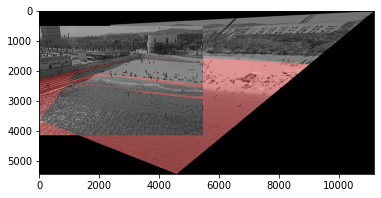

Error pixels: 6,671,804
Correct pixels: 34,523,716
image1.shape = (4320, 9536)	image2.shape = (4320, 9536)
cropping the upper left corner, shape 20000x20000
Error pixels: 6,671,804
Correct pixels: 34,523,716

---



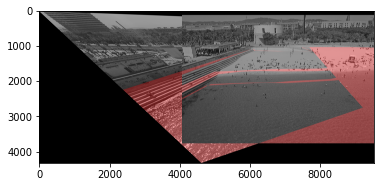

In [7]:
RADI = 2
HANDPICKED_KP = (
    (
        cv2.KeyPoint(3352, 1032, RADI),
        cv2.KeyPoint(5416, 1283, RADI),
        cv2.KeyPoint(3658, 1189, RADI),
        cv2.KeyPoint(4386, 1392, RADI)
        , cv2.KeyPoint(5049, 1209, RADI)
    ),
    (
        cv2.KeyPoint(1970, 972, RADI),
        cv2.KeyPoint(3720, 1063, RADI),
        cv2.KeyPoint(2358, 1087, RADI),
        cv2.KeyPoint(3091, 1200, RADI)
        , cv2.KeyPoint(3435, 1028, RADI)
    )
)

########################################################

H = homography_matrix_estimator(HANDPICKED_KP[0], HANDPICKED_KP[1])
print(H, end='\n\n')

blend_img = genera_error_annotaciones(image1, image2, mask1, mask2, np.linalg.inv(H), max_size_x=20000, max_size_y=20000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()

blend_img = genera_error_annotaciones(image2, image1, mask2, mask1, H, max_size_x=20000, max_size_y=20000)

plt.imshow(cv2.cvtColor(blend_img, cv2.COLOR_BGR2RGB))
plt.show()

The stiching is not that good but the mask should be reusable. Comparing the 4 and 5 points homography estimation, the 5 points is able to handle better the bleachers than the 4 points one.